<a target="_blank" href="https://colab.research.google.com/github/lukebarousse/Python_Data_Analytics_Course/blob/main/3_Project/5_Optimal_Skills.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# What is the most optimal skill to learn for Data Analysts?

#### Methodology

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

## Import Libraries and Data

Import the libraries, data and change the `job_posted_date` to a datetime type.

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


## Clean Data

Filters the original dataset to only get rows where the job title is 'Data Analyst' and the country is 'Italy', to create a new DataFrame `df_DA_IT`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in a new DataFrame (`df_DA_IT_exploded`) for each skill associated with a job. Finally, it displays the first 5 entries of the `salary_year_avg` and `job_skills` columns.

In [2]:
df_DA_IT = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Italy')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_IT = df_DA_IT.dropna(subset=['salary_year_avg'])

df_DA_IT_exploded = df_DA_IT.explode('job_skills')

df_DA_IT_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
107484,89100.0,r
107484,89100.0,python
107484,89100.0,java
107484,89100.0,flow
122754,53014.0,matlab


## Calculate Percent of Job Postings that Have Skills

Group the data by job skills and calculates the count and median salary for each skill, sorting the results in descending order by count. It then renames the columns. Calculates the percentage that each skill count represents out of the total number of Data Analyst jobs. Finally, filter out any skills that don't have any jobs associated with them.

In [3]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_IT_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_IT)  # Find count of Data Analyst jobs in Italy with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
python,7,89100.0,63.636364
sql,6,101500.0,54.545455
tableau,4,76757.0,36.363636
r,3,100500.0,27.272727
oracle,2,81094.5,18.181818
bigquery,2,75757.0,18.181818
excel,2,49007.0,18.181818
java,2,70057.0,18.181818
aws,1,102500.0,9.090909


## Median Salary vs Percent Skill Demand

Filters for Data Analyst skills that exceed a certain percentage (`skill_limit`).

In [85]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
python,7,89100.0,63.636364
sql,6,101500.0,54.545455
tableau,4,76757.0,36.363636
r,3,100500.0,27.272727
oracle,2,81094.5,18.181818
bigquery,2,75757.0,18.181818
excel,2,49007.0,18.181818
java,2,70057.0,18.181818
aws,1,102500.0,9.090909


Create a scatter plot to visualize the relationship between the percentage of Data Analyst jobs that require specific skills and the median salary for those skills.

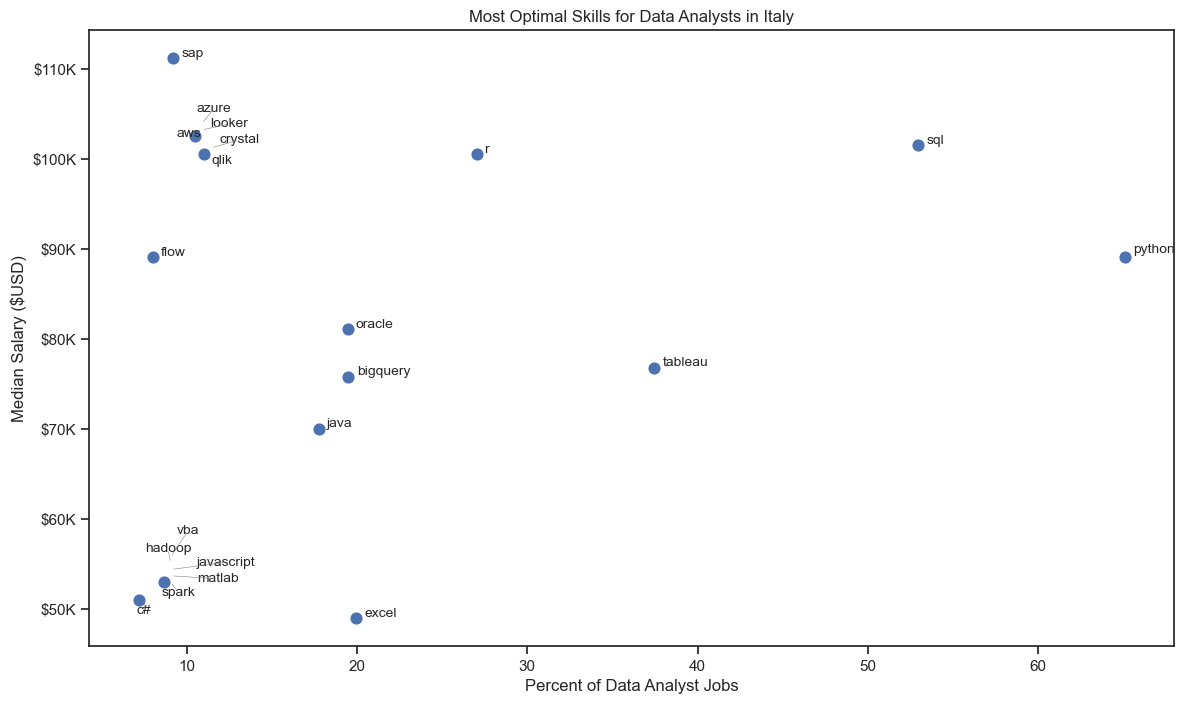

In [99]:
from adjustText import adjust_text
import numpy as np
import matplotlib.pyplot as plt

# --- Group skills that share the same point ---
df_grouped = (
    df_DA_skills_high_demand
    .reset_index()  # bring index (skill names) into a column
    .groupby(['skill_percent', 'median_salary'])['job_skills']  # 'index' column = skill names
    .apply(list)
    .reset_index()
)

# --- Add slight horizontal jitter ---
df_grouped['skill_percent_jittered'] = df_grouped['skill_percent'] + np.random.uniform(-2, 2, size=len(df_grouped))

# --- Plot the points ---
plt.figure(figsize=(14, 8))
plt.scatter(df_grouped['skill_percent_jittered'], df_grouped['median_salary'], s=60)

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in Italy')

ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
)

# --- Add stacked skill labels for each point ---
texts = []
for _, row in df_grouped.iterrows():
    x = row['skill_percent_jittered']
    y = row['median_salary']
    skills = row['job_skills']  # list of skill names sharing this point

    for j, skill in enumerate(skills):
        texts.append(
            plt.text(
                x + 0.4,       # slight horizontal offset
                y + j * 700,   # stack vertically
                skill,
                fontsize=10
            )
        )

# --- Adjust text to reduce overlap ---
adjust_text(
    texts,
    only_move={'texts': 'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.4),
    force_text=0.3,
    verbose=False
)

plt.show()

## Bonus: Coloring by Technology

We're going to add color labels based on technology.

Removes duplicate entries and any rows with missing values. Then, it combines all dictionary entries into a single dictionary, summing values for keys that repeat across entries. To ensure each key's values are unique, it converts the values to a set and then back to a list. The final result is a dictionary where each key represents a skill and each value is a list of unique attributes associated with that skill.

In [38]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['word',
  'excel',
  'sheets',
  'powerbi',
  'qlik',
  'dax',
  'powerpoint',
  'sas',
  'datarobot',
  'spreadsheet',
  'splunk',
  'microstrategy',
  'spss',
  'visio',
  'sharepoint',
  'ms access',
  'outlook',
  'alteryx',
  'ssrs',
  'nuix',
  'sap',
  'power bi',
  'msaccess',
  'ssis',
  'tableau',
  'cognos',
  'looker',
  'esquisse'],
 'programming': ['sass',
  'fortran',
  'objective-c',
  'typescript',
  'vba',
  'visualbasic',
  'visual basic',
  'bash',
  'julia',
  'erlang',
  'ocaml',
  'vb.net',
  'rust',
  'c#',
  'clojure',
  'go',
  'c',
  'f#',
  'cobol',
  'delphi',
  'matlab',
  'sas',
  'golang',
  'css',
  'pascal',
  'groovy',
  'solidity',
  'powershell',
  'mongodb',
  'perl',
  'python',
  'shell',
  'apl',
  'c++',
  'kotlin',
  'java',
  'lua',
  'javascript',
  'r',
  'elixir',
  'php',
  'lisp',
  'ruby',
  'html',
  'mongo',
  'assembly',
  'swift',
  'dart',
  'nosql',
  'no-sql',
  'scala',
  'crystal',
  'haskell',
  't-sql',
  '

This code converts a dictionary into a pandas DataFrame, then explodes the 'skills' column, creating multiple rows for each 'technology' entry if it contains multiple skills.

In [43]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology


,technology,skills
0,analyst_tools,word
0,analyst_tools,excel
0,analyst_tools,sheets
0,analyst_tools,powerbi
0,analyst_tools,qlik
...,...,...
9,sync,zoom
9,sync,twilio
9,sync,slack
9,sync,symphony


Merges two DataFrames, `df_DA_skills` and `df_technology`, based on the columns 'job_skills' and 'skills' respectively, creating a new DataFrame `df_DA_skills_tech`.

In [45]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,7,89100.0,63.636364,programming,python
1,6,101500.0,54.545455,programming,sql
2,4,76757.0,36.363636,analyst_tools,tableau
3,3,100500.0,27.272727,programming,r
4,2,81094.5,18.181818,cloud,oracle
5,2,75757.0,18.181818,cloud,bigquery
6,2,49007.0,18.181818,analyst_tools,excel
7,2,70057.0,18.181818,programming,java
8,1,102500.0,9.090909,cloud,aws
9,1,53014.0,9.090909,libraries,spark


Filters `df_DA_skills_tech` to select rows where the 'percent' column exceeds a specified threshold, storing the result in `df_DA_skills_tech_high_demand`. 

In [69]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

Plot the results in a scatter plot, coloring the points based on the 'technology' column.

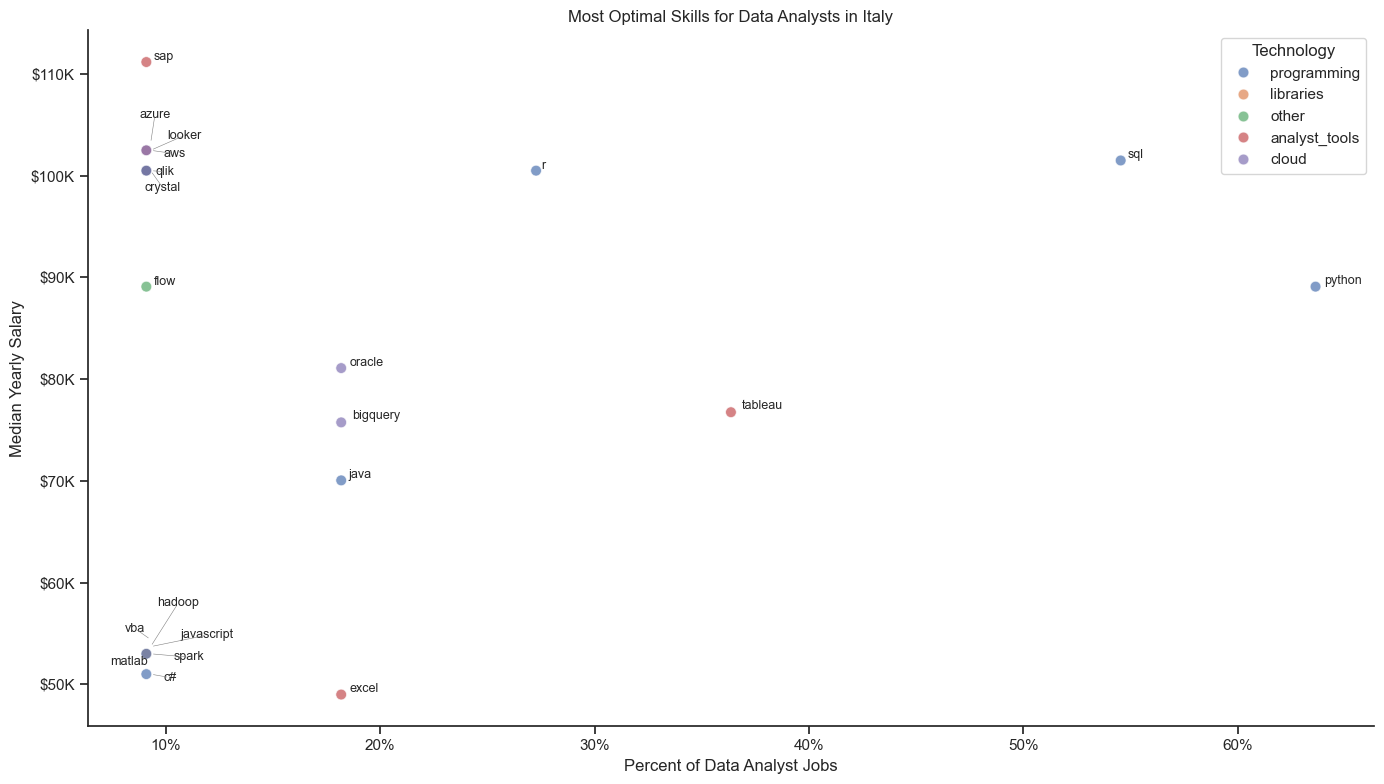

In [81]:
from adjustText import adjust_text
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- Group skills that share the same point ---
df_grouped = (
    df_DA_skills_tech_high_demand
    .groupby(['skill_percent', 'median_salary', 'technology'])['skills']
    .apply(list)
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=df_grouped,
    x='skill_percent',
    y='median_salary',
    hue='technology',
    s=60,
    alpha=0.7
)

sns.despine()
sns.set_theme(style='ticks')

# --- Labels & title ---
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in Italy')

# --- Axis formatting ---
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
)
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# --- Add multiple labels per point ---
texts = []

for _, row in df_grouped.iterrows():
    x = row['skill_percent']
    y = row['median_salary']
    skills = row['skills']

    for j, skill in enumerate(skills):
        texts.append(
            plt.text(
                x+0.2,
                y + j * 700,   # stack labels vertically
                skill,
                fontsize=9
            )
        )

# --- Light adjustText cleanup ---
adjust_text(
    texts,
    only_move={'texts': 'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.4),
    force_text=0.3,
    verbose=False
)

plt.legend(title='Technology')
plt.tight_layout()
plt.show()